In [60]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import sqlite3
import sys

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import time,warnings

from sklearn.linear_model import LinearRegression

In [61]:
conn = sqlite3.connect('../queries/retail.db')
df = pd.read_sql_query("SELECT * FROM mostvalue_client WHERE CustomerId IS NOT NULL", conn)
conn.close()

# dropping the variable, because the model will try to measurement the CustomerID.
# This can be have prior result in the model.

df = df.drop(columns=['CustomerID', 'avg_date', 'max_date', 'min_date', 'unique_items'])

df.isnull().sum()
df.head()

,total_items,avg_price_unit,total_revenue,total_transactions_appear
0,917,2.72,278571.62,1
1,208,4.94,259657.30,5
2,179,3.89,189650.73,3
3,2084,3.37,132572.62,1
4,515,2.36,123638.18,1


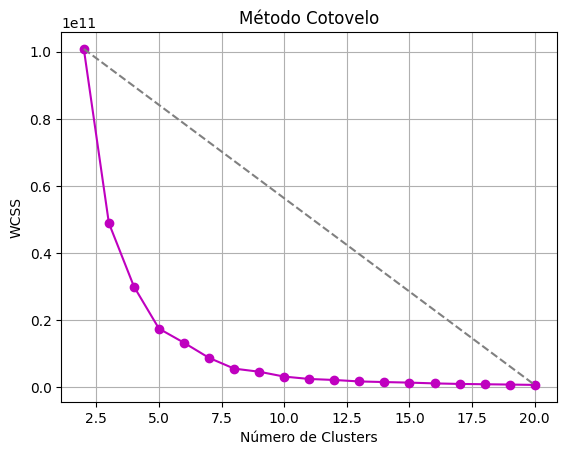

In [62]:

def calculate_wcss(data):
    wcss = []

    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)
    
    return wcss

wcss = calculate_wcss(df)
plt.plot(range(2,21), wcss, marker='o', color='m')
plt.plot([2, 20], [wcss[0], wcss[-1]], color='gray', linestyle='--')
plt.grid(True)
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.title('Método Cotovelo')
plt.show()


Estamos procurando o ponto que indica o maior equilíbrio entre maior homogeneidade dentro do cluster e a mior diferenca entre clusters, é o ponto da curva mais distante de uma reta tracaada entre os ponto (2, 20)

E temos a formula que calcula essa maior distância no nosso modelo: 

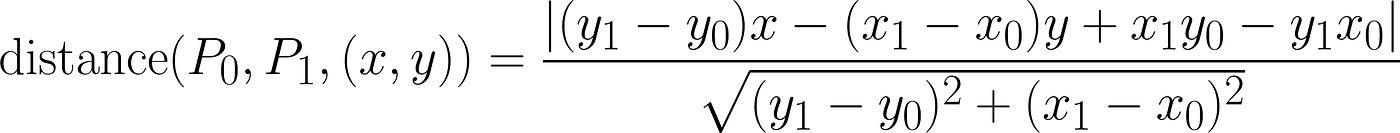

O nosso P0 é nosso: 2
O nosso P1 é nosso: 20

In [63]:
def good_optional_cluster(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[-1]

    distance = []

    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]

        numerator = abs((y2 - y1)*x0 - (x2 - x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distance.append(numerator / denominator)
    
    return distance.index(max(distance)) + 2

In [64]:
n = good_optional_cluster(wcss)
print(f'Número ótimo: {n} Clusters')

Número ótimo: 5 Clusters


In [65]:
kmeans = KMeans(n_clusters=n, n_init=10, random_state=42)
kmeans.fit(df)

df['Cluster'] = kmeans.labels_

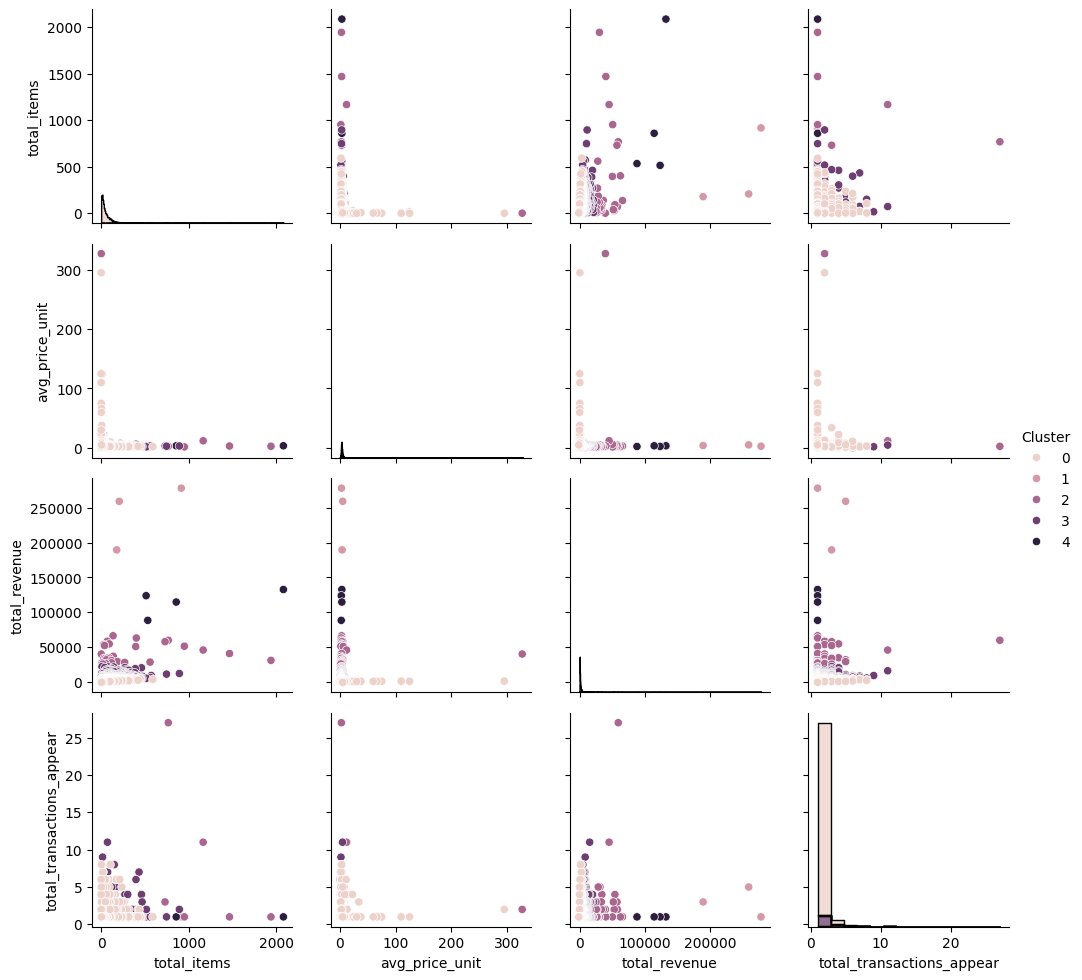

In [66]:
g = sns.PairGrid(df, hue="Cluster")
g.map_diag(sns.histplot, multiple="stack", element="step")
g.map_offdiag(sns.scatterplot)
g.add_legend()


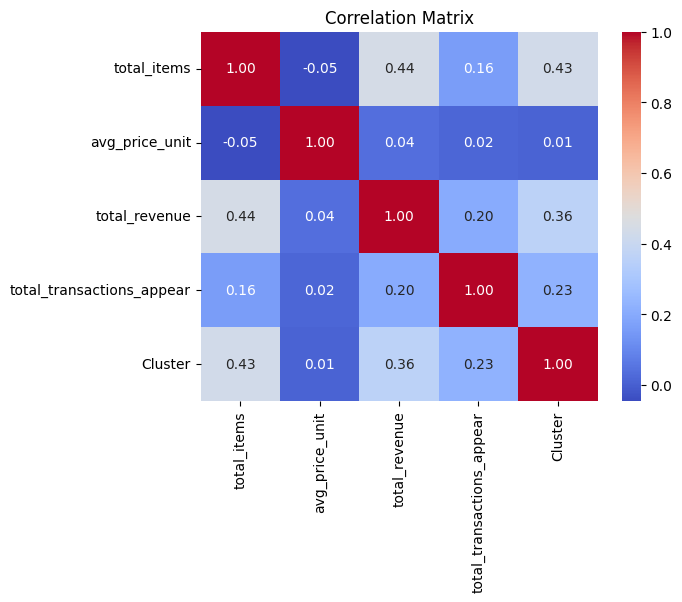

In [67]:
correlation_matrix = df.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()